<h1> Modelling and evaluation </h1>
<h2> 1. Importing libraries and downloading datasets </h2>

In [417]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import tensorflow as tf
import random


from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score as ACC
from sklearn.ensemble import RandomForestClassifier

from tensorflow import keras
from keras import layers
from keras.layers import RNN, Dense, Dropout, BatchNormalization
from keras import Sequential, layers, Input, callbacks

from xgboost import XGBClassifier 
from sklearn.model_selection import GridSearchCV
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.model_selection import cross_val_score

from numpy import array
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Embedding,Dense

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Flatten ,Embedding,Input
from keras.models import Model

from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV


import warnings
warnings.filterwarnings('ignore')

In [418]:
# Importing all the datasets
A_tra_X = pd.read_csv('data/train_A.csv')
A_val_X = pd.read_csv('data/val_A.csv')
A_test_X = pd.read_csv('data/test_A.csv')


B_tra_X = pd.read_csv('data/train_B.csv')
B_val_X = pd.read_csv('data/val_B.csv')
B_test_X = pd.read_csv('data/test_B.csv')


C_tra_X = pd.read_csv('data/train_C.csv')
C_val_X = pd.read_csv('data/val_C.csv')
C_test_X = pd.read_csv('data/test_C.csv')


D_tra_X = pd.read_csv('data/train_D.csv')
D_val_X= pd.read_csv('data/val_D.csv')
D_test_X = pd.read_csv('data/test_D.csv')

tra_y = pd.read_csv('data/train_y.csv')
val_y = pd.read_csv('data/val_y.csv')
test_y = pd.read_csv('data/test_y.csv')

tra_y_eye = np.eye(10)[list(tra_y['0'])]
val_y_eye = np.eye(10)[list(val_y['0'])]
test_y_eye = np.eye(10)[list(test_y['0'])]

<h2> 2. Benchmarks </h2>
<h3> 2.1 Naive Benchmark, Monte Carlo Method </h3>
<p> Using 1000 simulations with random guesses on target labels. </p>

In [419]:
def naive_benchmark_MonC(y):
    accuracy_list = []
    for i in range(0,1000,1):
        naive_rand_pred = np.random.randint(0,12,size=(len(y)))
        accuracy_sel = ACC(naive_rand_pred, y)
        accuracy_list.append(accuracy_sel)
    return np.mean(accuracy_list)

In [420]:
naive_benchmark_MonC(test_y)

0.08226495726495728

<h3> 2.2 Naive Benchmark, Majority Class Method </h3>
<p> Using Frodo, which equals label 2, as guess </p>

In [421]:
def naive_benchmark_MajC(y):                
    pred_MCNB =np.repeat(2,len(y))
    return ACC(pred_MCNB, y)

In [422]:
naive_benchmark_MajC(test_y)

0.1752136752136752

<h2> 3. Modelling  </h2>
<!-- <h3> 3.1 ANN on dataset A</h3> -->
<!-- <p> Dataset A contains various numerical retrieved from the characters. </p>
<p> The feedforward neural network has a relative simple architecture. -->

<h3> 3.1 XGBC on dataset D

In [423]:
p_g = {
    'alpha': hp.uniform('alpha',0,1),
    'gamma': hp.uniform('gamma',0,9),
    'reg_lambda':hp.quniform('reg_lamda',0,3,1),
    'max_depth':hp.quniform('max_depth',6,12,1),
    'learning_rate': hp.uniform('learning_rate',0.001,0.05),
    'n_estimators': hp.quniform('n_estimators', 5,500,1),
    'min_child_weight': hp.quniform('min_child_weight',0,5,1),
    'seed':42
    }

In [424]:
def bayopt_xgb(p_g):
    internal_model = XGBClassifier(
                     objective='multi:softmax',
                     alpha=p_g['alpha'],
                     gamma=p_g['gamma'],
                     reg_lambda= p_g['reg_lambda'],
                     max_depth = int(p_g['max_depth']),
                     n_estimator = (p_g['n_estimators']),
                     learning_rate=p_g['learning_rate'],
                     min_child_weight=p_g['min_child_weight'],
                     seed =p_g['seed'],
                     )
    internal_model.set_params(random_state=42)
    internal_model.fit(D_tra_X, tra_y,
                     eval_set = [(D_val_X, val_y)],
                     eval_metric = 'mlogloss',
                     early_stopping_rounds=25,verbose=False)
    score =np.mean(cross_val_score(internal_model, D_tra_X, tra_y, scoring='accuracy', cv=3))
    print('Score:', score)
    return {'loss':-score, 'status':STATUS_OK}

def tune():
    trials = Trials()
    best_tune = fmin(fn=bayopt_xgb, 
                    space=p_g,
                    algo= tpe.suggest,
                    max_evals=10,
                    trials=trials)
    return best_tune


ntune = tune()
ntune['n_estimators'] =  int(ntune['n_estimators'])
ntune['max_depth'] =  int(ntune['max_depth'])
xmodel = XGBClassifier(**ntune)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

Score:                                                
0.2397463763163051                                    
Score:                                                                           
0.21968795993784718                                                              
Score:                                                                           
0.21968795993784718                                                              
Score:                                                                           
0.28680528025736013                                                              
Score:                                                                            
0.2092463740379752                                                                
Score:                                                                            
0.200529483867146                                                                 
Score:                                                            

In [425]:
xmodel.fit(D_tra_X, tra_y)

XGBClassifier(alpha=0.6351896914703837, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.14061054625809466, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.043647200278740604,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1.0, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=73, n_jobs=None,
              num_parallel_tree=None, ...)

In [426]:
print('Accuracy train: ',ACC(xmodel.predict(D_tra_X),tra_y))
print('Accuracy validation: ',ACC(xmodel.predict(D_val_X),val_y))
print('Accuracy test: ',ACC(xmodel.predict(D_test_X),test_y))

Accuracy train:  0.5030514385353095
Accuracy validation:  0.2874015748031496
Accuracy test:  0.3418803418803419


<h3> 3.2 ANN on dataset A </h3>

In [427]:
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)

ann_model = keras.Sequential([
    layers.Dense(20, activation='relu',input_dim=20),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.3),
    layers.Dense(16, activation='gelu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(8, activation='relu'),
    layers.Dense(10, activation='softmax'),
])

optimizer = keras.optimizers.Adam(learning_rate=0.03)
ann_model.compile(optimizer=optimizer,
              loss = 'categorical_crossentropy',
              metrics=['accuracy']
              )

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, 
    patience=30, 
    restore_best_weights=True,
)
history = ann_model.fit(A_tra_X, tra_y_eye, 
          validation_data= (A_val_X, val_y_eye),
          epochs=150, batch_size=30, 
          callbacks=early_stopping,
          verbose=1
          )


Epoch 1/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.1130 - loss: 2.3646 - val_accuracy: 0.1299 - val_loss: 2.2599
Epoch 2/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1222 - loss: 2.2797 - val_accuracy: 0.1339 - val_loss: 2.2242
Epoch 3/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1292 - loss: 2.2664 - val_accuracy: 0.1732 - val_loss: 2.1944
Epoch 4/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1232 - loss: 2.2640 - val_accuracy: 0.1890 - val_loss: 2.2044
Epoch 5/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1532 - loss: 2.2612 - val_accuracy: 0.1299 - val_loss: 2.2419
Epoch 6/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1350 - loss: 2.2636 - val_accuracy: 0.1575 - val_loss: 2.2108
Epoch 7/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1361 - loss: 2.2605 - val_accuracy: 0.1772 - val_loss: 2.2027
Epoch 8/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1406 - loss: 2.2528 - val_accuracy: 0.1732 - 

In [428]:
# Train accuracy
ann_model.evaluate(A_tra_X, tra_y_eye)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1670 - loss: 2.2376


[2.23629093170166, 0.16564951837062836]

In [429]:
# Validation accuracy
ann_model.evaluate(A_val_X, val_y_eye)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - accuracy: 0.1478 - loss: 2.2210


[2.1944096088409424, 0.17322835326194763]

In [430]:
# Test accuracy
ann_model.evaluate(A_test_X, test_y_eye)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1591 - loss: 2.1670 


[2.1843435764312744, 0.19230769574642181]

<h3> 3.3 RFC on dataset C </h3>

In [432]:
param_grid = {
    'n_estimators': [30,35,45],
    'max_depth': [6,9,12,15,16],
}

C_train = pd.concat([C_tra_X, C_val_X],axis=0).reset_index(drop=True)
C_target = pd.concat([tra_y, val_y],axis=0).reset_index(drop=True)

rfc = RandomForestClassifier(random_state=50)
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='accuracy', 
                           n_jobs=-1, error_score='raise')
grid_search.fit(C_train, C_target)

GridSearchCV(cv=5, error_score='raise',
             estimator=RandomForestClassifier(random_state=50), n_jobs=-1,
             param_grid={'max_depth': [6, 9, 12, 15, 16],
                         'n_estimators': [30, 35, 45]},
             scoring='accuracy')

In [433]:
best_params = grid_search.best_params_
best_params

{'max_depth': 15, 'n_estimators': 35}

In [434]:
rfc_model = RandomForestClassifier(**best_params, random_state=50)
rfc_model.fit(C_train, C_target)
train_pred = rfc_model.predict(C_train)
test_pred = rfc_model.predict(C_test_X)

print('Accuracy train:',ACC(train_pred, C_target))
print('Accuracy test:',ACC(test_pred, test_y))

Accuracy train: 0.5467523197715917
Accuracy test: 0.3547008547008547


<h2> 4. Ensemble model </h2>

In [435]:
# XGBC
P1 = xmodel.predict(D_test_X)

# LSTM
pp2 = ann_model.predict(A_test_X)
P2 = pp2.argmax(axis=1)

# RFC
P3 = rfc_model.predict(C_test_X)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


In [436]:
final_preds = []
for i in range(len(P1)):
    preds =  [P1[i],P2[i],P3[i]]
    if preds[0]==preds[1]:
        ans = preds[0]
    elif preds[0]==preds[2]:
        ans= preds[0]
    elif preds[1]==preds[2]:
        ans=preds[1]
    else:
        ans = preds[2]
    final_preds.append(ans)
ACC(final_preds, test_y)

0.358974358974359

In [437]:
def evaluate_model(pred, target):
    eval_methods = [ f1_score, precision_score, recall_score]

    print(classification_report(target,pred))
    print("Accuracy ", round(ACC(target,pred), 4)) 
    
    for e in eval_methods:
        print(str(e.__name__), round(e(pred, target, average='weighted'), 4)) 
    # return pred  

In [438]:
imp_char = ['ARAGORN', 'FARAMIR', 'FRODO', 'GANDALF', 'GIMLI', 'GOLLUM', 'MERRY', 'PIPPIN', 'SAM', 'THEODEN']

def conf_matrix(y, pred):
    cm = confusion_matrix(pred,y)/np.sum(confusion_matrix(pred,y))
    plt.figure(figsize=(10,10)) 
    ax = sns.heatmap(cm, annot=False, 
                fmt='.1%', cmap='Blues', 
                xticklabels=imp_char, yticklabels=imp_char)
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    return ax

In [439]:
def part_A(A,B,C):
    obs_tot_list = []
    for i in range(0,len(A),1):
        ptot_list = []
        for j  in range(0,10,1):
            p1 = A[j][i]
            p2  = B[j][i]
            p3 = C[j][i]
            ptot = sum([p1,p2,p3])
            ptot_list.append(ptot)
        obs_tot_list.append(ptot_list)
    return obs_tot_list
    

In [440]:
a = xmodel.predict_proba(D_test_X)
b = emb_model.predict(D_test_X)
c = rfc_model.predict_proba(C_test_X)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


<h2>5. Results: </h2>
<h3> 5.1 XGBC

In [441]:
evaluate_model(P1, test_y)

              precision    recall  f1-score   support

           0       0.16      0.54      0.24        28
           1       0.33      0.17      0.22         6
           2       0.62      0.37      0.46        41
           3       0.50      0.45      0.48        33
           4       0.75      0.18      0.29        17
           5       0.45      0.56      0.50        18
           6       0.12      0.07      0.09        14
           7       0.25      0.17      0.20        24
           8       0.52      0.32      0.40        37
           9       0.44      0.25      0.32        16

    accuracy                           0.34       234
   macro avg       0.42      0.31      0.32       234
weighted avg       0.44      0.34      0.35       234

Accuracy  0.3419
f1_score 0.3306
precision_score 0.426
recall_score 0.3419


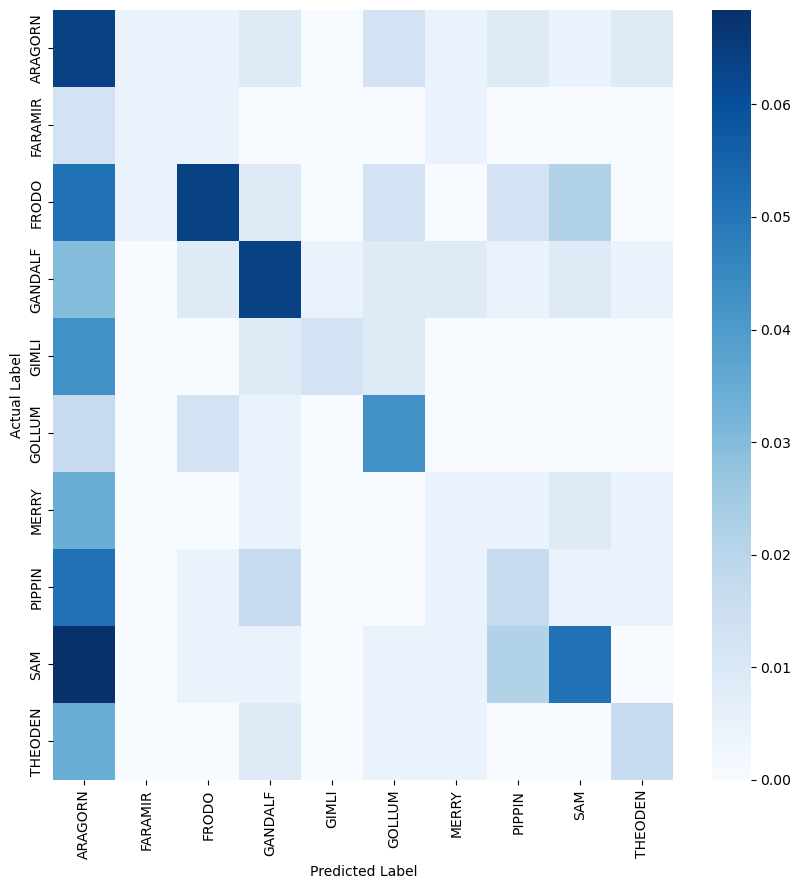

In [442]:
conf_matrix(P1, test_y)
plt.show()

<h3> 5.2 ANN

In [443]:
evaluate_model(P2, test_y)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.00      0.00      0.00         6
           2       0.19      0.85      0.30        41
           3       0.22      0.30      0.26        33
           4       0.00      0.00      0.00        17
           5       0.00      0.00      0.00        18
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00        24
           8       0.00      0.00      0.00        37
           9       0.00      0.00      0.00        16

    accuracy                           0.19       234
   macro avg       0.04      0.12      0.06       234
weighted avg       0.06      0.19      0.09       234

Accuracy  0.1923
f1_score 0.2951
precision_score 0.7478
recall_score 0.1923


<Axes: xlabel='Predicted Label', ylabel='Actual Label'>

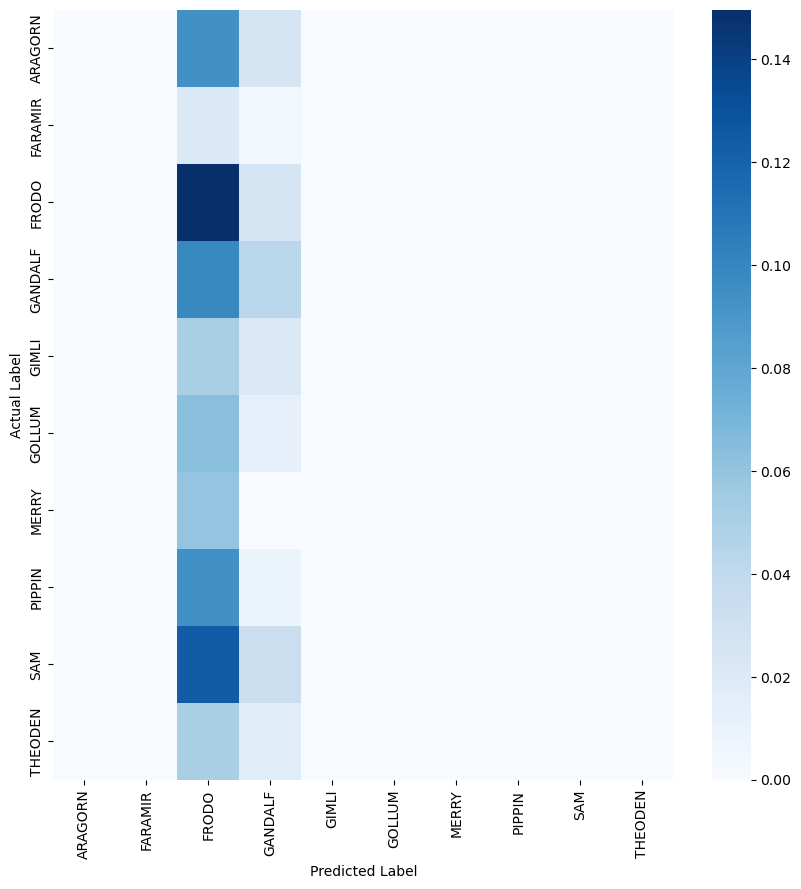

In [444]:
conf_matrix(P2, test_y)

<h3> 5.3 RFC

In [445]:
evaluate_model(P3, test_y)

              precision    recall  f1-score   support

           0       0.38      0.18      0.24        28
           1       0.00      0.00      0.00         6
           2       0.23      0.71      0.34        41
           3       0.54      0.42      0.47        33
           4       0.50      0.06      0.11        17
           5       0.50      0.56      0.53        18
           6       0.50      0.07      0.12        14
           7       0.62      0.21      0.31        24
           8       0.48      0.43      0.46        37
           9       1.00      0.12      0.22        16

    accuracy                           0.35       234
   macro avg       0.48      0.28      0.28       234
weighted avg       0.48      0.35      0.33       234

Accuracy  0.3547
f1_score 0.378
precision_score 0.5617
recall_score 0.3547


<Axes: xlabel='Predicted Label', ylabel='Actual Label'>

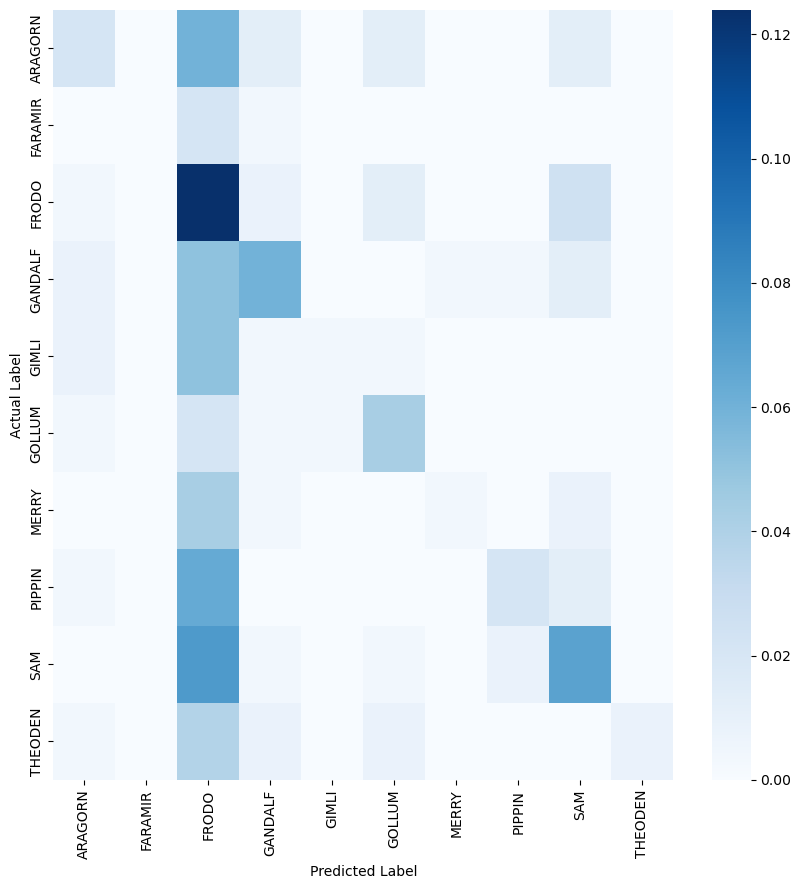

In [446]:
conf_matrix(P3, test_y)

<h3> 5.4 Ensemble


In [447]:
evaluate_model(final_preds, test_y)

              precision    recall  f1-score   support

           0       0.42      0.18      0.25        28
           1       0.00      0.00      0.00         6
           2       0.23      0.71      0.35        41
           3       0.52      0.48      0.50        33
           4       0.50      0.06      0.11        17
           5       0.50      0.56      0.53        18
           6       0.50      0.07      0.12        14
           7       0.71      0.21      0.32        24
           8       0.47      0.41      0.43        37
           9       1.00      0.12      0.22        16

    accuracy                           0.36       234
   macro avg       0.48      0.28      0.28       234
weighted avg       0.48      0.36      0.33       234

Accuracy  0.359
f1_score 0.384
precision_score 0.5656
recall_score 0.359


<Axes: xlabel='Predicted Label', ylabel='Actual Label'>

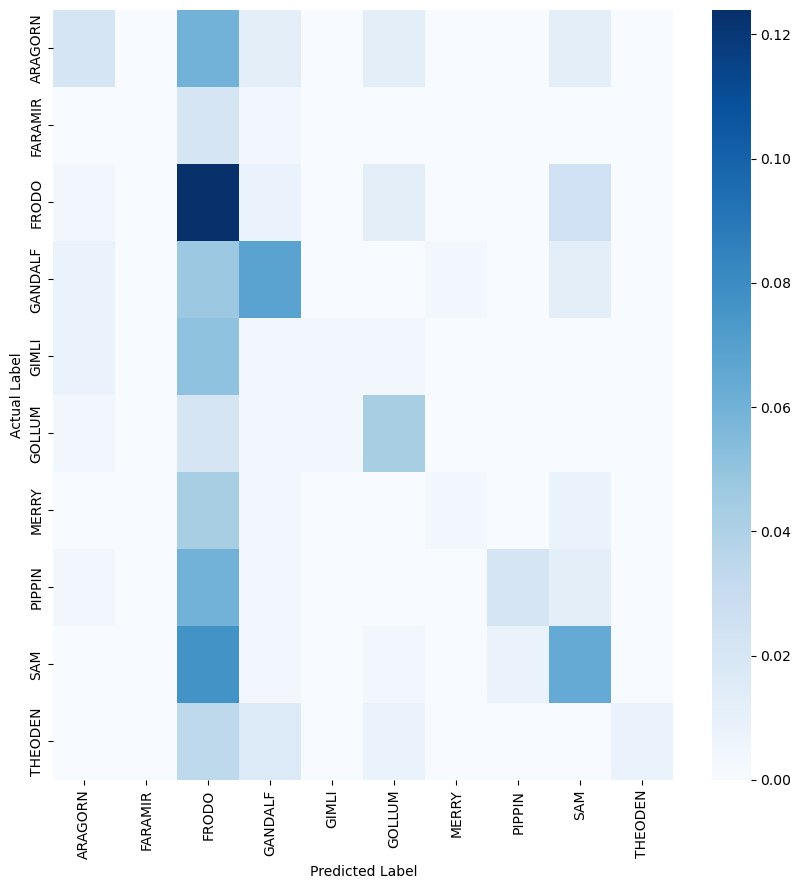

In [448]:
conf_matrix(final_preds, test_y)

<h2> 5.5 Naive Benchmark Majority Class

In [449]:
evaluate_model(test_y, np.repeat(2,len(final_preds)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       1.00      0.18      0.30       234
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

    accuracy                           0.18       234
   macro avg       0.10      0.02      0.03       234
weighted avg       1.00      0.18      0.30       234

Accuracy  0.1752
f1_score 0.0522
precision_score 0.0307
recall_score 0.1752
